In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict

from collections import namedtuple
from itertools import product
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display , clear_output
import pandas as pd
import time 
import json

In [35]:
def get_corr_predicted(predictions,labels):
    return predictions.argmax(dim=1).eq(labels).sum().item()

In [36]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4,out_features=120)
        self.fc2 = nn.Linear(in_features = 120 , out_features = 60 )
        self.out = nn.Linear(in_features=60 , out_features=10)
        
    def forward(self,t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)
        
        t = self.conv2(t)
        t  = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)
        
        t =  t.reshape(-1,12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)
        t = F.relu(t)
        
        t = self.out(t)
        return t

In [40]:
train_set  = torchvision.datasets.FashionMNIST(
root= "MNIST/",
    train = True ,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [41]:
batch_size= 100
lr = 0.01
train_data_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)

In [13]:
network = Network()
optimizer = optim.Adam(network.parameters(),lr=lr)
batch = next(iter(train_data_loader))
images,labels = batch

preds = network(images)
loss  = F.cross_entropy(preds,labels)
loss.backward()
optimizer.step()

print("Loss 1: ",loss.item())
preds =  network(images)
loss = F.cross_entropy(preds,labels)
print("Loss 2: ",loss.item())

Loss 1:  2.304344415664673
Loss 2:  2.2817962169647217


In [17]:
comment = f' batch_size={batch_size} lr={lr}'
tb = SummaryWriter(comment=comment)
images,labels = next(iter(train_data_loader))
grid = torchvision.utils.make_grid(images)
tb.add_image('images',grid)
tb.add_graph(network,images)
tb.close()

batch_list  = [100,1000,10000]
lr_list = [.01,.001,.0001,.00001]
for batch_size in batch_list:
        for lr in lr_list:
            network = Network()
            
            train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size)
            optimizer = optim.Adam(network.parameters(),lr=lr)
            
            images,labels = next(iter(train_loader))
            grid  = torchvision.utils.make_grid(images)
            comment = f'batch size={batch_size} lr={lr}'
            
            tb = SummaryWriter(comment=comment)
            tb.add_image('images',grid)
            tb.add_graph(network,images)
            
            for epoch in range(5):
                total_loss = 0
                total_correct = 0
                for batch in train_loader:
                    images, labels = batch
                    preds  = network(images)
                    loss = F.cross_entropy(preds,labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                    total_correct += get_corr_predicted(preds,labels)
                    
                tb.add_scalar('Loss',total_loss,epoch)
                tb.add_scalar('Number correct ' ,total_correct,epoch)
                tb.add_scalar('Accuracy',total_correct/len(train_set),epoch)
                
                for name,param in network.named_parameters():
                    tb.add_histogram(name,param,epoch)
                    tb.add_histogram(f'{name}.grad',param.grad,epoch)
                    
                print("epoch",epoch,
                     "total correct:",total_correct,
                     "loss:",total_loss)
                tb.close()

  

epoch 0 total correct: 46989 loss: 338.95388609170914
epoch 1 total correct: 51476 loss: 230.5381393879652
epoch 2 total correct: 52060 loss: 214.1304852515459
epoch 3 total correct: 52426 loss: 202.73804092407227
epoch 4 total correct: 52557 loss: 198.6076188236475
epoch 0 total correct: 41963 loss: 480.2937106490135
epoch 1 total correct: 48440 loss: 311.1770951151848
epoch 2 total correct: 50198 loss: 270.261054366827
epoch 3 total correct: 51064 loss: 245.79708871245384
epoch 4 total correct: 51630 loss: 228.13991124927998
epoch 0 total correct: 30094 loss: 859.1488131284714
epoch 1 total correct: 42807 loss: 469.32205736637115
epoch 2 total correct: 44250 loss: 421.12240222096443
epoch 3 total correct: 45064 loss: 394.60435324907303
epoch 4 total correct: 45751 loss: 375.96648156642914
epoch 0 total correct: 8988 loss: 1363.1896991729736
epoch 1 total correct: 26724 loss: 1216.6816473007202
epoch 2 total correct: 31889 loss: 935.0115466117859
epoch 3 total correct: 37079 loss: 738

In [42]:
test_images = [image[0] for image in iter(train_set) ]
test_labels = [label[1] for label in iter(train_set)]

In [43]:
def make_predictions(img_index):
    predics =  network(test_images[img_index].unsqueeze(dim=1))
    print(predics.argmax())
    plt.imshow(test_images[img_index].squeeze())

In [44]:
 make_predictions(34)

NameError: name 'network' is not defined

In [45]:
#Confusion matrix
preds.grad_fn

NameError: name 'preds' is not defined

In [46]:
@torch.no_grad()
def get_all_preds(model,loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images,labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds,preds),dim=0)
    return all_preds

In [48]:
# prediction_loader = torch.utils.data.DataLoader(train_set,batch_size=10000)
# train_preds = get_all_preds(network,prediction_loader)
# preds_correct = get_corr_predicted(train_preds,train_set.targets)

In [42]:
print(train_set.targets)
print(train_preds.argmax(dim=1))

tensor([9, 0, 0,  ..., 3, 0, 5])
tensor([9, 0, 6,  ..., 3, 0, 5])


In [44]:
stacked = torch.stack((train_set.targets,train_preds.argmax(dim=1)),dim=1)

In [46]:
stacked.shape

torch.Size([60000, 2])

In [47]:
stacked[0].tolist()

[9, 9]

In [49]:
cmt = torch.zeros(10,10,dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [52]:
for p in stacked:
    tl,pl = p.tolist()
    cmt[tl,pl] = cmt[tl,pl]+1

In [53]:
cmt

tensor([[4896,   18,  118,  128,   12,    0,  795,    0,   33,    0],
        [   2, 5943,    2,   37,    4,    1,    9,    0,    2,    0],
        [  46,   12, 5188,   49,  343,    0,  358,    0,    4,    0],
        [  97,  182,   34, 5449,   64,    0,  172,    0,    2,    0],
        [   3,    8,  566,  364, 4551,    0,  503,    0,    5,    0],
        [   1,    0,    2,    1,    0, 5848,    3,  104,   19,   22],
        [ 665,   24,  618,  126,  355,    0, 4195,    0,   17,    0],
        [   0,    0,    1,    0,    0,   34,    6, 5840,    8,  111],
        [   3,    5,   39,   23,   45,    4,   61,    3, 5817,    0],
        [   1,    1,    1,    3,    0,   35,    2,  221,    3, 5733]])

In [56]:
cm2 = confusion_matrix(train_set.targets,train_preds.argmax(dim=1))

In [58]:
cm2

array([[4896,   18,  118,  128,   12,    0,  795,    0,   33,    0],
       [   2, 5943,    2,   37,    4,    1,    9,    0,    2,    0],
       [  46,   12, 5188,   49,  343,    0,  358,    0,    4,    0],
       [  97,  182,   34, 5449,   64,    0,  172,    0,    2,    0],
       [   3,    8,  566,  364, 4551,    0,  503,    0,    5,    0],
       [   1,    0,    2,    1,    0, 5848,    3,  104,   19,   22],
       [ 665,   24,  618,  126,  355,    0, 4195,    0,   17,    0],
       [   0,    0,    1,    0,    0,   34,    6, 5840,    8,  111],
       [   3,    5,   39,   23,   45,    4,   61,    3, 5817,    0],
       [   1,    1,    1,    3,    0,   35,    2,  221,    3, 5733]],
      dtype=int64)

In [63]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[4896,   18,  118,  128,   12,    0,  795,    0,   33,    0],
        [   2, 5943,    2,   37,    4,    1,    9,    0,    2,    0],
        [  46,   12, 5188,   49,  343,    0,  358,    0,    4,    0],
        [  97,  182,   34, 5449,   64,    0,  172,    0,    2,    0],
        [   3,    8,  566,  364, 4551,    0,  503,    0,    5,    0],
        [   1,    0,    2,    1,    0, 5848,    3,  104,   19,   22],
        [ 665,   24,  618,  126,  355,    0, 4195,    0,   17,    0],
        [   0,    0,    1,    0,    0,   34,    6, 5840,    8,  111],
        [   3,    5,   39,   23,   45,    4,   61,    3, 5817,    0],
        [   1,    1,    1,    3,    0,   35,    2,  221,    3, 5733]])


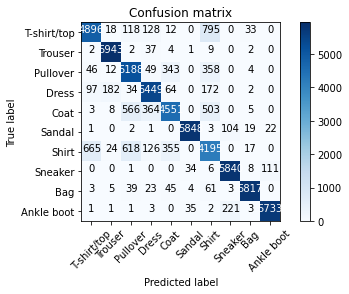

In [65]:
plot_confusion_matrix(cmt,train_set.classes)

## Coding Run builder

In [51]:
params = OrderedDict(
    lr = [0.01,0.001],
    batch_size = [1000,10000]
)

In [82]:
class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss  = 0
        self.epoch_num_correct = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None
        self.loader = None
        self.tb = None
    
    def begin_run(self,run,network,loader):
        self.run_start_time = time.time()
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader  =loader
        self.tb  = SummaryWriter(comment=f'--{run}')
        
        images,labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('images',grid)
        self.tb.add_graph(self.network,images)
        
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
        
    def begin_epoch(self):
        self.epoch_start_time  = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy  = self.epoch_num_correct / len(self.loader.dataset)
        
        self.tb.add_scalar('Loss',loss,self.epoch_count)
        self.tb.add_scalar('Accuracy',accuracy,self.epoch_count)
        
        for name , param in self.network.named_parameters():
            self.tb.add_histogram(name,param,self.epoch_count)
            self.tb.add_histogram(f'{name}.grad',param.grad,self.epoch_count)
            
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data,orient="columns")
        clear_output(wait=True)
        display(df)
        
    def track_loss(self,loss):
        self.epoch_loss += loss.item() * self.loader.batch_size
    
    def track_num_correct(self,preds,labels):
        self.epoch_num_correct = self._get_num_correct(preds,labels)
    
    @torch.no_grad()
    def _get_num_correct(self,preds,labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self,fileName):
        pd.DataFrame.from_dict(self.run_data,orient='columns').to_csv(f'{fileName}.csv')
        with open(f'{fileName}.json','w+',encoding="utf-8") as f:
            json.dump(self.run_data,f,ensure_ascii=False,indent=4)
            
        

In [83]:
params.keys()

odict_keys(['lr', 'batch_size'])

In [84]:
params.values()

odict_values([[0.01], [1000, 2000]])

In [85]:
Run = namedtuple('Run',params.keys())

In [86]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run',params.keys())
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

In [87]:
for run in RunBuilder.get_runs(params):
    comment = f'-{run}'
    print(comment)

-Run(lr=0.01, batch_size=1000)
-Run(lr=0.01, batch_size=2000)


In [88]:
#With Run manager
params = OrderedDict(
    lr = [0.01],
    batch_size = [1000,2000]
)
m = RunManager()
for run in RunBuilder.get_runs(params):
    network = Network()
    loader = DataLoader(train_set,batch_size=run.batch_size)
    optimizer = optim.Adam(network.parameters(),lr=run.lr)
    m.begin_run(run,network,loader)
    for epoch in range(5):
        m.begin_epoch()
        for batch in loader:
            images = batch[0]
            labels  = batch[1]
            preds  = network(images)
            loss =  F.cross_entropy(preds,labels)
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss)
            m.track_num_correct(preds,labels)
        
        m.end_epoch()
    m.end_run()
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size
0,1,1,2.203015,0.003683,7.959663,8.486641,0.01,1000
1,1,2,2.587154,0.001733,8.319115,16.872267,0.01,1000
2,1,3,2.465391,0.001417,8.990619,25.914890,0.01,1000
3,1,4,2.440736,0.001800,8.723996,34.691885,0.01,1000
4,1,5,2.517769,0.001717,9.090027,43.834914,0.01,1000
5,2,1,2.050115,0.007200,10.756499,11.917008,0.01,2000
6,2,2,2.285328,0.008533,9.554361,21.542371,0.01,2000
7,2,3,3.400401,0.003150,9.403018,31.011391,0.01,2000
8,2,4,3.055444,0.003200,9.171818,40.258758,0.01,2000
9,2,5,2.638506,0.003450,8.881459,49.201217,0.01,2000
